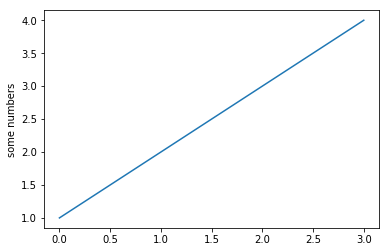

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.show()

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import expanduser
import re 

#Load Data

dates = ["Oct18" , "Oct23" ]


train_path = []; test_path = []; labels_path = []; matchMatrixfileName = [];
 
save_path = os.path.join(expanduser("~"), 'Traversability_project/imageVelDataset/augmented_data/class_' ) 
matchMatrixes_Path = os.path.join(expanduser("~"),'Traversability_project/imageVelDataset/timeStampsAndMatchMatrixes')

for date in dates:

    train_path.append( os.path.join(expanduser("~"),'Traversability_project/imageVelDataset/imagesCV2'  + date) )
    labels_path.append(os.path.join(expanduser("~"),'Traversability_project/imageVelDataset/vel'  + date) )

    matchMatrixfileName.append(os.path.join(matchMatrixes_Path, "convensionMatrix_" + date + ".npy" ) )


## Load Y data to get classes distribution

In [3]:
import copy
Y = []

for i in xrange(0, len(dates)):

    matchMatrix = np.load(matchMatrixfileName[i])    
    dataSet_names = copy.copy(matchMatrix[:,0])

    for dataSetNum in dataSet_names:
        identifierVel = matchMatrix[np.where(matchMatrix == dataSetNum)[0][0],1]

        label = np.load(os.path.join(labels_path[i], "vel_"+str(identifierVel) + ".npy"))
        Y.append(label)
        
Y = np.array(Y)
Y = Y[:,1]
print "Shape Y: " + str(Y.shape) + " without having split in train and test"

print "Classes: " + str(np.unique(Y))

Shape Y: (6784,) without having split in train and test
Classes: [-0.15009464  0.          0.15009464]


In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
print "Classes: " + str(le.classes_) + "\nCorrespondence: " +str(le.transform(le.classes_))
Y_labels = le.transform(Y)

Classes: [-0.15009464  0.          0.15009464]
Correspondence: [0 1 2]


## Original data prob. distribution

In [5]:
prob = []
print("Original data prob. distribution:")
labelsNum = Y_labels
for k in xrange(le.classes_.size):
    print(np.sum(labelsNum==k)/float(labelsNum.size)*100)
    prob.append(np.sum(labelsNum==k)/float(labelsNum.size))

Original data prob. distribution:
12.1757075472
75.1031839623
12.7211084906


In [6]:
#code
import random
from scipy import ndimage
from skimage.util import random_noise
import skimage

#random Rotation 
rg = 20
percent_rot = 0.3
#Gaussian noise
percent_gauss = 0.1
    

for k in xrange(le.classes_.size):
    print "Class: " + str(k)
    X = []
    

    
    for i in xrange(0, len(dates)):  #acumm images of the same class, for all the datasets
        
        matchMatrix = np.load(matchMatrixfileName[i])    
        dataSet_names = copy.copy(matchMatrix[:,0])

        for dataSetNum in dataSet_names:
            identifierVel = matchMatrix[np.where(matchMatrix == dataSetNum)[0][0],1]

            label = np.load(os.path.join(labels_path[i], "vel_"+str(identifierVel) + ".npy"))
            
            if(le.transform([label[1]]) == k ):
                
                img_name = "image_"+str(dataSetNum) + ".jpg"  #"image_0.jpg" 
                img = cv2.imread(os.path.join(train_path[i], img_name))
                
                X.append(img)
                
    #Convert list to np.array      
    X = np.array(X) 
    print "Shape X: " + str(X.shape)
    
    #Complete amount to have a balances class:
    if(prob[k] != max(prob)):
    #Repeat X to get the amount of images of the majority class
    
        factor = int((max(prob)*labelsNum.size)/(prob[k]*labelsNum.size))
        repeated_X = np.repeat(X, factor, axis=0)
        np.random.shuffle(repeated_X)
        
        #Complete the amount of images that reamins to complete the complete amount. The one corresponding to the decimal part of the division
        if(repeated_X.shape[0] < max(prob)*labelsNum.size):
            diff = int(max(prob)*labelsNum.size - repeated_X.shape[0])
            sample_imgs = random.sample(X, diff)
            #Concatenate repeated_X with the new sample to complete the same ampunt of the majority class
            repeated_X = np.concatenate((repeated_X, np.array(sample_imgs)), axis=0)

    else:
        repeated_X = X
        
    #----------------------------------------
    #Data augmentation: Do data transformations to diversify the data 
    
    #random Rotation 
    ind_mod = random.sample(range(repeated_X.shape[0]), int(repeated_X.shape[0]*percent_rot))

    for index in ind_mod:
        angle = np.random.uniform(-rg, rg)
        repeated_X[index] = ndimage.rotate(repeated_X[index], angle, mode='reflect', reshape=False)
    
    #Gausssian noise
    ind_mod = random.sample(range(repeated_X.shape[0]), int(repeated_X.shape[0]*percent_gauss))

    for index in ind_mod:
        repeated_X[index] = skimage.img_as_ubyte(random_noise(repeated_X[index], mode='gaussian', seed=None, clip=True))
               
    #----------------------------------------
    #Save images
    
    for img_indx in xrange(repeated_X.shape[0]):
        name = "image_"+str(img_indx) + ".jpg"
        #Save Image
        cv2.imwrite(os.path.join(save_path + str(k), name) , repeated_X[img_indx])
        
    del(repeated_X)

print("All images saved")       

Class: 0
Shape X: (826, 360, 480, 3)


/home/mcalvarez/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Class: 1
Shape X: (5095, 360, 480, 3)
Class: 2
Shape X: (863, 360, 480, 3)
All images saved


## -----------------------------------------------------------------

In [ ]:
------------Data augmentation------------
No flips. 
Rotación de máximo +- 20 grado, con diferentes rotaciones. 30% de las imágenes. 
Ruido gaussiano . 10% de las imágenes

------------------------------------------------
#pseudo-code
for k in xrange(le.classes_.size):
    print k
    X = []
    
    for i in xrange(0, len(dates)):  #acumm images of the same class, for all the datasets
        
        matchMatrix = np.load(matchMatrixfileName[i])    
        dataSet_names = copy.copy(matchMatrix[:,0])

        for image in images_all_classes_in_dataset
        
            if(image_class == k )
            x_for_one_class.append (image) 
            
    
    x_for_one_class  --> do replication of the data to equal the amount max(prob)*labelsNum.size in this class

    x_for_one_class --> do augmentation modifications to the balanced data  with certain prob 

    
    
    for num_for_name in xrange(x_for_one_class)  
    
        save x_for_one_class in folder[k] with name num_for_name
            

In [ ]:
------------------------------------------------------------------------

angle: 7.9636474617


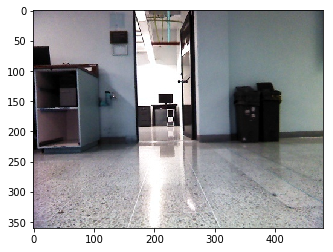

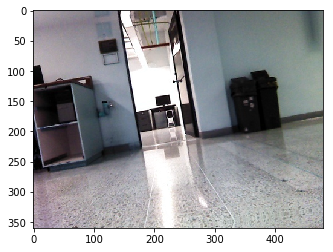

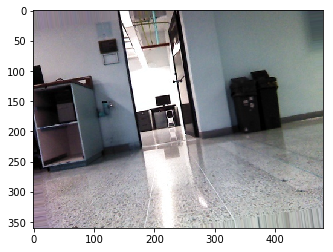

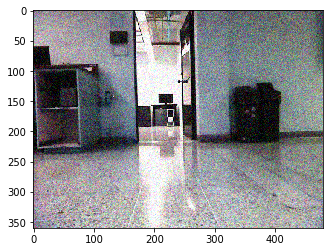

In [5]:
from scipy import ndimage
from skimage.util import random_noise


imgg = cv2.imread(os.path.join(save_path + str(0), "image_0.jpg"))

rg = 20

angle = np.random.uniform(-rg, rg)

print "angle: " + str(angle)

plt.imshow(imgg)
plt.show()

rotated = ndimage.rotate(imgg, angle, mode='reflect' , reshape=False)
plt.imshow(rotated)
plt.show()
#rotation angle in degree
rotated = ndimage.rotate(imgg, angle, mode='nearest' ,reshape=False) # (‘constant’, ‘nearest’, ‘reflect’ or ‘wrap’
plt.imshow(rotated)
plt.show()


noise = random_noise(imgg, mode='gaussian', seed=None, clip=True)
plt.imshow(noise)
plt.show()

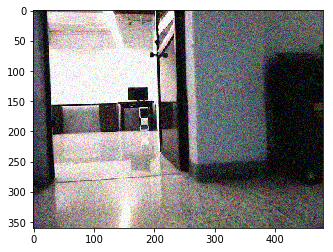

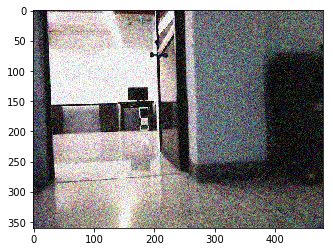

(360, 480, 3)
(360, 480, 3)


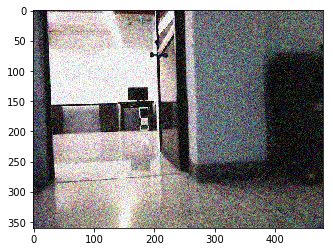

In [57]:
index = 8
plt.imshow(X[index])
plt.show()
img = skimage.img_as_ubyte(random_noise(X[index] , mode='gaussian', seed=None, clip=True))
plt.imshow(img)
plt.show()
print img.shape
X[index, :, : , :] = img
print X[index].shape
plt.imshow(X[index] )
plt.show()